In [1]:
from openmmtools.testsystems import WaterBox
import matplotlib.pyplot as plt
from simtk import unit
import numpy as np
import torchani
import torch
import time
from IPython.core.display import display, HTML

# openmm units
distance_unit = unit.nanometer

# ANI-1 units and conversion factors
ani_distance_unit = unit.angstrom

nm_to_angstroms = (1.0 * distance_unit) / (1.0 * ani_distance_unit)

# hartree to kJ/mol conversion factor
hartree_to_kJ_mol = 2625.499638

nr_of_atoms = []
times_with_pbc = []
times_without_pbc = []
platform = 'cpu'

# testing different edge length
species = None
coordinates = None
device = None
model = None

for box_length in [8]:
    
    torchani.nn.torch.cuda.empty_cache()
    device = torch.device(platform)
    model = torchani.models.ANI1ccx()
    model = model.to(device)

    # generate waterbox
    testsystem = WaterBox(box_edge=box_length*unit.angstrom)
    x = testsystem.positions
    dhfr_elements = [atom.element.symbol for atom in testsystem.topology.atoms()]
    print('Nr of atoms in the system: {}'.format(len(dhfr_elements)))
    element_string = ''.join(dhfr_elements)
    
    nr_of_atoms.append(len(dhfr_elements))

    # species and coordinates to torch
    species = model.species_to_tensor(element_string).to(device).unsqueeze(0)

    coordinates = torch.tensor([x.value_in_unit(unit.nanometer)],
                            requires_grad=True, device=device, dtype=torch.float32)

    
    print(testsystem.system.getDefaultPeriodicBoxVectors())
    # define cell vector
    cell_vectors = torch.tensor([[box_length, 0.0, 0.0], [0.0, box_length, 0.0], [0.0, 0.0, box_length]], dtype=torch.float32)
    # define dimensions to update
    cell = torch.tensor([True, True, True], dtype=torch.bool)

    
    #############################
    # energy & force calculation without pbc
    #############################
    t0 = time.time()
    # calculate energy
    _, energy_in_hartree = model((species, coordinates * nm_to_angstroms))
    energy_in_kJ_mol = energy_in_hartree * hartree_to_kJ_mol
    print('Energy: {} kJ/mol'.format(energy_in_kJ_mol[0]))
    # calculate force
    derivative = torch.autograd.grad((energy_in_kJ_mol).sum(), coordinates)[0]
    F = - np.array(derivative.cpu())[0] 
    
    # get time
    t1 = time.time()
    t = t1-t0
    print('time: {}'.format(t))
    times_without_pbc.append(t)
    
    
    #############################
    # energy & force calculation with pbc
    #############################
    t0 = time.time()
    # calculate energy
    _, energy_in_hartree = model((species, coordinates * nm_to_angstroms, cell_vectors, cell))
    energy_in_kJ_mol = energy_in_hartree * hartree_to_kJ_mol
    print('Energy: {} kJ/mol'.format(energy_in_kJ_mol[0]))
    # calculate force
    derivative = torch.autograd.grad((energy_in_kJ_mol).sum(), coordinates)[0]
    F = - np.array(derivative.cpu())[0] 
    
    # get time
    t1 = time.time()
    t = t1-t0
    print('time: {}'.format(t))   
    times_with_pbc.append(t)

# plot results
plt.plot(nr_of_atoms, times_without_pbc, label='Energy evaluation without pbc')
plt.plot(nr_of_atoms, times_with_pbc, label='Energy evaluation with pbc')
plt.title('Nr of atoms vs time')
plt.xlabel('Nr of atoms')
plt.ylabel('Time [sec]')
plt.legend()
plt.show()


Nr of atoms in the system: 45
[Quantity(value=(0.8, 0.0, 0.0), unit=nanometer), Quantity(value=(0.0, 0.8, 0.0), unit=nanometer), Quantity(value=(0.0, 0.0, 0.8), unit=nanometer)]
Energy: -3008459.0 kJ/mol
time: 0.16685914993286133
tensor([[8., 0., 0.],
        [0., 8., 0.],
        [0., 0., 8.]])
tensor([True, True, True], dtype=torch.bool)
tensor([[ 1,  1,  1],
        [ 1,  1,  0],
        [ 1,  1, -1],
        [ 1,  0,  1],
        [ 1,  0,  0],
        [ 1,  0, -1],
        [ 1, -1,  1],
        [ 1, -1,  0],
        [ 1, -1, -1],
        [ 0,  1,  1],
        [ 0,  1,  0],
        [ 0,  1, -1],
        [ 0,  0,  1]])
Energy: -3007058.5 kJ/mol
time: 0.8183488845825195


<Figure size 640x480 with 1 Axes>

In [4]:
torchani.__version__

'0.8'

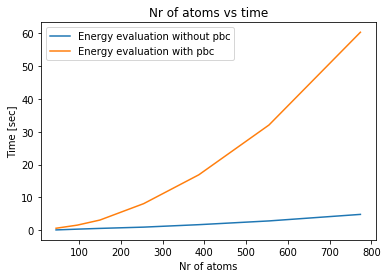

In [2]:
plt.plot(nr_of_atoms, times_without_pbc, label='Energy evaluation without pbc')
plt.plot(nr_of_atoms, times_with_pbc, label='Energy evaluation with pbc')
plt.title('Nr of atoms vs time')
plt.xlabel('Nr of atoms')
plt.ylabel('Time [sec]')
plt.legend()
plt.show()
